<a href="https://github.com/cuongvng/neural-networks-with-PyTorch/blob/master/CNNs/ResNet/ResNet.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

In [1]:
!pip install git+https://github.com/cuongvng/neural-networks-with-PyTorch.git

  Cloning https://github.com/cuongvng/neural-networks-with-PyTorch.git to /tmp/pip-req-build-8jow6467
  Running command git clone -q https://github.com/cuongvng/neural-networks-with-PyTorch.git /tmp/pip-req-build-8jow6467
  Created wheel for train-plot-utils: filename=train_plot_utils-1.0-cp36-none-any.whl size=4715 sha256=73528871a6413f8659343916197d939ce87db7e7f233d0ab74906be215263c3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-aan8diye/wheels/72/21/a6/2c9910e6fda85ce86b2c6a011cbc2f3eff8020634fa90e427e
Successfully built train-plot-utils


In [2]:
!nvidia-smi

Mon Jun 22 17:05:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append("../..")
from utils.training_helpers import train_cnn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load CIFAR dataset

In [4]:
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor() # convert data from PIL image to tensor
                                ]) 
cifar_train = torchvision.datasets.CIFAR10(root="../data/", train=True, 
                                     transform=transform, 
                                     target_transform=None, 
                                     download=True)
cifar_test = torchvision.datasets.CIFAR10(root="../data/", train=False, 
                                     transform=transform, 
                                     target_transform=None, 
                                     download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=cifar_train,
    batch_size=128,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=cifar_test,
    batch_size=128,
    shuffle=True,

)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


Let's dive into ResNet's architechture.
There are multiple types of ResNet, such as ResNet-18, ResNet-34, ResNet-50, ResNet-152, etc., but they has the same core: the **Residual Block**.
In this notebook, I will demonstrate the ResNet-34.

<figure>
    <center><img src="https://github.com/d2l-ai/d2l-en/blob/master/img/resnet-block.svg?raw=1"/></center>
    <center><figcaption class="center">Residual Block</figcaption></center>
</figure>

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_1x1_conv=False):
        super(ResidualBlock, self).__init__()

        self.use_1x1_conv = use_1x1_conv
        self.conv3x3_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv3x3_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, X):
        X_clone = X.clone()
        
        X = self.conv3x3_1(X)
        X = F.relu(self.bn(X))
        X = self.conv3x3_2(X)
        X = self.bn(X)
        
        if self.use_1x1_conv:
            X_clone = self.conv1x1(X_clone)

        return F.relu(X + X_clone)

Let's see the structures of different ResNet variants. 

![Structures of ResNets](https://github.com/cuongvng/neural-networks-with-PyTorch/blob/resnet/CNNs/ResNet/img/ResNetStructures.png?raw=1)
Source: [the original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)



As we can see, all the variants have the two `7x7 Conv` and `3x3 MaxPooling` layers at the beginning and the two `AvgPooling` and `Dense` Layers at the end. The difference lies in the intermediate layers, which contains multiple stacked Residual Blocks, which are denoted inside big square brackets.

Note that we add a BatchNormalization layer after each Convolutional layer.
Now let's implement the whole ResNet-34 model.

In [6]:
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        
        # Declare each layer on the table above:
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(num_features=64), 
            nn.ReLU()
        )
        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ResidualBlock(in_channels=64, out_channels=64), 
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64), 
        )
        
        # The first Residual Block in each subsequent layer use 1x1 convolutional layer and `stride=2` 
        # to halve the height and width of the input tensor.
        # This does not apply to the above `self.conv2_x` because it already has the `MaxPool2d` layer to do so.
        
        self.conv3_x = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=128, stride=2, use_1x1_conv=True), 
            ResidualBlock(in_channels=128, out_channels=128), 
            ResidualBlock(in_channels=128, out_channels=128), 
            ResidualBlock(in_channels=128, out_channels=128), 
        )
        self.conv4_x = nn.Sequential(
            ResidualBlock(in_channels=128, out_channels=256, stride=2, use_1x1_conv=True), 
            ResidualBlock(in_channels=256, out_channels=256), 
            ResidualBlock(in_channels=256, out_channels=256), 
            ResidualBlock(in_channels=256, out_channels=256), 
            ResidualBlock(in_channels=256, out_channels=256), 
            ResidualBlock(in_channels=256, out_channels=256), 
        )
        self.conv5_x = nn.Sequential(
            ResidualBlock(in_channels=256, out_channels=512, stride=2, use_1x1_conv=True), 
            ResidualBlock(in_channels=512, out_channels=512), 
            ResidualBlock(in_channels=512, out_channels=512), 
        )
        
        # The Global Average Pooling layer will be replaced by an average pooling function in the `forward` method.
        # The reason why I do not declare it as a torch.nn layer here is that for Global Pooling, the kernel size is the 
        # shape (height, width) of the input tensor, thus it outputs an 1x1 tensor (over the channel dimension).
        # And since I do not know (or just be lazy to calculate) its kernel size, I will print the input shape
        # at the `forward` method to get the kernel size.
        
        # The last dense layer will output 10 classes for the CIFAR dataset, not 1000 for the ImageNet dataset as on the table.
        self.fc = nn.Linear(in_features=512, out_features=10)
        
    def forward(self, X):
        X = X.type(torch.float)
        
        X = self.conv1(X)
        X = self.conv2_x(X)
        X = self.conv3_x(X)
        X = self.conv4_x(X)
        X = self.conv5_x(X)
        
        # Apply global avg pooling 2d (kernel size = (height, width) to get output's spatial dimension = (1,1))
        X = F.avg_pool2d(X, kernel_size=(X.shape[2], X.shape[3]))
        X = torch.flatten(X, start_dim=1)
        X = self.fc(X)
        
        return X

In [7]:
net = ResNet34()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

Total training time: 2:12:48.553995
train loss: 0.1112 
train acc: 0.9609 
test acc: 0.8321


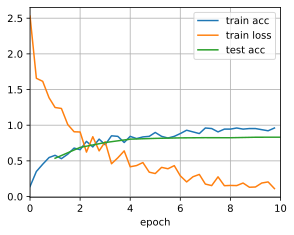

In [9]:
n_epochs = 10
train_cnn(net, device, train_loader, test_loader, optimizer, criterion, n_epochs)